# Comparing Spectra

This notebooks demonstrates how you can use the χ² metric to compare spectra.

In [21]:
using NeXLSpectrum
using DataFrames, Gadfly, InvertedIndices

In [22]:
specs = [ loadspectrum(joinpath(raw"C:\Users\nritchie\Documents\FY2022\DODOA EDS QC\10-Jan-2022\Manual","IIIE K412[$i][3].msa")) for i in 0:4 ]

5-element Vector{Spectrum{Float64}}:
 Spectrum{Float64}[IIIE K412[0][all], 2.58389 + 9.99864⋅ch eV, 4096 ch, 20.0 keV, K412, 6.44e6 counts]
 Spectrum{Float64}[IIIE K412[1][all], 2.58389 + 9.99864⋅ch eV, 4096 ch, 20.0 keV, K412, 6.44e6 counts]
 Spectrum{Float64}[IIIE K412[2][all], 2.58389 + 9.99864⋅ch eV, 4096 ch, 20.0 keV, K412, 6.45e6 counts]
 Spectrum{Float64}[IIIE K412[3][all], 2.58389 + 9.99864⋅ch eV, 4096 ch, 20.0 keV, K412, 6.45e6 counts]
 Spectrum{Float64}[IIIE K412[4][all], 2.58389 + 9.99864⋅ch eV, 4096 ch, 20.0 keV, K412, 6.45e6 counts]

In [23]:
det = matching(specs[1], 132.0)

BasicEDS[4096 chs, 2.58389 + 9.99864⋅ch eV, 132.0 eV @ Mn K-L3, 1 ch LLD, [Be,Sc,Ba,Pu]]

In [24]:
set_default_plot_size(8inch, 4inch)
elms = [ n"C",n"O",n"Mg",n"Al",n"Si",n"Ca",n"Fe" ]
# plot(specs..., xmax=12.0e3, klms=elms)

7-element Vector{Element}:
 Element(Carbon)
 Element(Oxygen)
 Element(Magnesium)
 Element(Aluminium)
 Element(Silicon)
 Element(Calcium)
 Element(Iron)

I'll present two different ways to compare spectra.
  * Direct spectrum to spectrum comparison (`χ²(...)`)
  * Comparing a spectrum to the sum of the other spectra (`similarity(...)`).

First, `χ²`.  This metric will be approximately unity when the spectra differ only by count statistics.  

Overall, the spectra compare very well one to another.  The largest `χ²` metric is 1.10 when comparing one spectrum to another over large ROI.

In [25]:
fullroi = channel(100.0, det):channel(10.0e3, det)
χ²(specs, fullroi)

5×5 Matrix{Float64}:
    0.0    1020.88   995.206  997.722  1088.22
 1020.88      0.0    979.742  998.507  1013.8
  995.206   979.742    0.0    961.053   976.453
  997.722   998.507  961.053    0.0     937.162
 1088.22   1013.8    976.453  937.162     0.0

However, individual peaks can compare less well.

In [26]:
χ²(specs, NeXLSpectrum.fwhmroi(specs[1], n"Si K-L3"))

5×5 Matrix{Float64}:
 0.0       6.78062   6.79688   9.54306   5.37196
 6.78062   0.0      10.2712   16.9399   10.5116
 6.79688  10.2712    0.0      10.2049    0.98205
 9.54306  16.9399   10.2049    0.0       8.49895
 5.37196  10.5116    0.98205   8.49895   0.0

In [27]:
χ²(specs, NeXLSpectrum.fwhmroi(specs[1], n"Fe K-L3"))

5×5 Matrix{Float64}:
  0.0       5.0342    8.54218  11.8589   13.0329
  5.0342    0.0      10.0157    7.45117   9.54829
  8.54218  10.0157    0.0      13.8535   10.2126
 11.8589    7.45117  13.8535    0.0      15.7439
 13.0329    9.54829  10.2126   15.7439    0.0

In [28]:
χ²(specs, NeXLSpectrum.fwhmroi(specs[1], n"O K-L3"))

5×5 Matrix{Float64}:
  0.0       4.01239  9.69215  17.7303   28.7199
  4.01239   0.0      7.79901  11.8719   25.8071
  9.69215   7.79901  0.0       3.34689   6.66464
 17.7303   11.8719   3.34689   0.0       6.22052
 28.7199   25.8071   6.66464   6.22052   0.0

In [29]:
χ²(specs, NeXLSpectrum.fwhmroi(specs[1], n"Mg K-L3"))

5×5 Matrix{Float64}:
 0.0       8.22987   9.94782   2.72169   5.35568
 8.22987   0.0      11.4878    9.39366   8.36689
 9.94782  11.4878    0.0      12.1918   13.5127
 2.72169   9.39366  12.1918    0.0       2.2342
 5.35568   8.36689  13.5127    2.2342    0.0

However, the `χ²` matrices can be hard to interpret.  Which spectrum is the "problem child"?   What we really want to know is how each spectrum compares with the mean of the others.

We want to retain the spectra that are most similar to the mean.  That is what `similarity(...)` is used for.

In [30]:
using Statistics
NeXLSpectrum.similarity(specs, det, n"O")

5-element Vector{Float64}:
 1.510312985973718
 1.2388275573468728
 0.6653228173105655
 1.3338255027184582
 2.06757098843039

In [42]:
ENV["columns"]=200
df=DataFrame( 
    :Spectrum=>name.(specs), 
    map(elm->Symbol(elm.symbol)=>NeXLSpectrum.similarity(specs, det, elm), elms)...,
    :All => NeXLSpectrum.similarity(specs)
)
insertcols!(df, :Mean=>map(r->mean(r[2:end-1]), eachrow(df)))
using PrettyTables
open(joinpath(homedir(),"Desktop", "k412compare.tex"),"w") do io
    pretty_table(io, df, backend = Val(:latex), table_type=:tabular, nosubheader=true, 
      formatters = ft_printf("%6.4f"), alignment = [ :l, :l, :l, :l, :l, :l, :l, :l, :l, :l ],
      title = raw"""
        Comparing 5 spectra collected from K412 glass using the \metric metric over ranges of channels corresponding to the elements in the column headers.  The All
        and Mean columns reflect the \metric metric over \SI{100}{\eV} to $E_0$ and the mean of all element metrics, respectively.""",
      label = "tbl:k412compare"
    )
  end
  df

,Spectrum,C,O,Mg,Al,Si,Ca,Fe,All,Mean
,SubStrin…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,IIIE K412[0][all],0.752944,1.51031,1.15027,1.23354,1.17751,1.47857,0.989181,1.04268,1.18462
2,IIIE K412[1][all],0.991844,1.23883,1.02099,1.15049,1.81148,1.031,0.982283,1.00692,1.17527
3,IIIE K412[2][all],0.615758,0.665323,1.11139,1.00769,1.24561,1.11764,1.02264,1.00339,0.969437
4,IIIE K412[3][all],1.02272,1.33383,0.556986,0.951959,1.62699,1.19424,0.910547,0.995285,1.08533
5,IIIE K412[4][all],0.775855,2.06757,0.951594,0.898125,0.99717,0.841283,1.13582,1.00252,1.09535


We expect a bit of variation in O since the soft X-ray is quite susceptible to absorption and topography.  

Let's remove spectra 1 and 4 and see what happens.

In [32]:
using Statistics
for elm in elms
    println( ( mean(NeXLSpectrum.similarity(specs, det, elm)), std(NeXLSpectrum.similarity(specs, det, elm))) )
end

(0.8318253422459458, 0.1718201270876415)
(1.3631719703560008, 0.5052585090220634)
(0.9582440564960193, 0.2373362361928849)
(1.0483615688070889, 0.1398559685664196)
(1.3717523420924753, 0.3363250417770381)
(1.1325482433073382, 0.23393694358833322)
(1.0080957263973978, 0.08225871599218175)


As we increase the X-ray energy, the variability decreases.

Let's try applying these functions to a spectrum that we know should compare well since they represent sub-samplings of the same source.

  * `subdivide(...)` takes a single spectrum and distributes the counts at random among N spectra creating N spectra that sums to the original spectrum.
  * `subsample(...)` takes a single spectrum and emulates taking a fraction of the same live-time.  The results won't necessarily sum to the original.

In [33]:
sd=mapreduce(_->subdivide(specs[1], 8), append!, 1:6)
describe(DataFrame(
    :Spectrum=>eachindex(sd),
    [ Symbol(symbol(elm))=>NeXLSpectrum.similarity(sd, det, elm) for elm in elms]...
)[:,2:end], :mean, :std, :max, :min)

,variable,mean,std,max,min
,Symbol,Float64,Float64,Float64,Float64
1,C,0.864826,0.293948,1.80862,0.302374
2,O,0.854832,0.276174,1.85621,0.460516
3,Mg,0.853506,0.200003,1.27782,0.394415
4,Al,0.91462,0.255155,1.49924,0.297589
5,Si,0.928637,0.262336,1.50286,0.544608
6,Ca,0.864907,0.157421,1.11847,0.572802
7,Fe,0.917072,0.116429,1.18863,0.746547


In [34]:
sd2=mapreduce(_->map(i->subsample(specs[1], 0.1),1:8),append!,1:10)
describe(DataFrame(
    :Spectrum=>eachindex(sd2),
    [ Symbol(symbol(elm))=>NeXLSpectrum.similarity(sd2, det, elm) for elm in elms]...
)[:,2:end], :mean, :std, :max, :min)

,variable,mean,std,max,min
,Symbol,Float64,Float64,Float64,Float64
1,C,0.891988,0.282776,1.52841,0.262456
2,O,0.890837,0.286179,2.01925,0.371919
3,Mg,0.858633,0.243994,1.43875,0.428418
4,Al,0.92503,0.229124,1.5771,0.52459
5,Si,0.94246,0.24582,1.79296,0.5111
6,Ca,0.91132,0.165708,1.37674,0.61856
7,Fe,0.896138,0.12114,1.17104,0.618218


Interestingly, these are consistently slightly less than unity?  Why?

In [35]:
using Distributions

In [36]:
σ=10.0
n=Normal(0.0,σ)
mean(mean((rand(n,15).^2))-σ^2 for i in 1:100000)

0.015166609872030761

In [37]:
p1, p2 = Dict(:ProbeCurrent=>1.0, :LiveTime=>10.0),Dict(:ProbeCurrent=>1.0, :LiveTime=>0.99*40.0)
r = rand(1:10000, 2048)
d1, d2 = Poisson.(r), Poisson.(4r)
s1 = Spectrum(det.scale, [ rand(d) for d in d1], p1)
s2 = Spectrum(det.scale, [ rand(d) for d in d2], p2)
NeXLSpectrum.similarity(s1,s2,1:2048)

1.4935791914593541

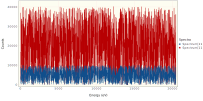

In [18]:
plot(s1,s2)

In [19]:
p1, p2 = Dict(:ProbeCurrent=>1.0, :LiveTime=>10.0),Dict(:ProbeCurrent=>1.0, :LiveTime=>40.0)
mean(map(1:1000) do i
    r = rand(1:100, 2048)
    d1, d2 = Poisson.(r), Poisson.(4r)
    s1 = Spectrum(det.scale, [ rand(d) for d in d1], p1)
    s2 = Spectrum(det.scale, [ rand(d) for d in d2], p2)
    NeXLSpectrum.similarity(s1, s2, 10:20)
end)

1.0039067304532736

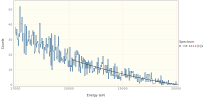

In [20]:
p=plot(specs[1],duanehunt=true, xmin=17000.0)
#p |> SVG(raw"C:\users\nritchie\Desktop\duane_hunt.svg", 6inch, 4inch)
p

In [43]:
duane_hunt(specs[1])

19972.88154579493